# Solar Sizing Optimization code 


In [60]:

#Imports 
import pvlib
from pvlib.location import Location
from pvlib import pvsystem, location, modelchain, iotools
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import pathlib
from datetime import datetime
from dataclasses import dataclass
import sqlite3

In [61]:
#Worst day from PlantWaterCalcs.ipynb
Q_max = 20.7504 #m3/day for 1ha
day_max = pd.to_datetime('2020-06-11').date()
max_flow_rate = (2*50*34) /(1000*3600) #m3/s
time_min = (Q_max) / (max_flow_rate* 3600) #hours


#Pump P vs Q equation from PumpCurve.ipynb --> P = a*Q^3 + b*Q^2 + c*Q + c
a = 445687894.591783
b = -984696.5871017637
c = 854.0710206707552
d = -0.05692714507987253

max_power = a*(max_flow_rate**3) + b*(max_flow_rate**2) + c*max_flow_rate + d #kw



In [39]:
max_power

0.24682734083929322

In [62]:
#Import and clean Solar data 
con = sqlite3.connect("../NetworkCode/SolarData.sqlite")
df_weather_CEBIVE_raw = pd.read_sql_query("SELECT * from cebiveSolarDailyHourly", con)
con.close()

#Convert date to datetime
df_weather_CEBIVE_raw['iso_date'] = pd.to_datetime(df_weather_CEBIVE_raw['iso_date'])
df_weather_CEBIVE_raw.index = pd.to_datetime(df_weather_CEBIVE_raw['iso_date'])

#Only data where location is CEBIVE and date is day_max
df_weather = df_weather_CEBIVE_raw[(df_weather_CEBIVE_raw['location'] == 'CEBIVE') & (df_weather_CEBIVE_raw['iso_date'].dt.date == day_max)]

#Formatting data to input into pvlib model
weather = pd.DataFrame({
    'ghi': df_weather['Cloudy_sky.ghi'], 'dhi': df_weather['Cloudy_sky.dhi'], 'dni': df_weather['Cloudy_sky.dni'],
    'temp_air':  df_weather['Temp'], 'wind_speed':  df_weather['wind_speed'], 
})

loc = location.Location(18.541, -69.990, -4.00, 32.0) #CEBIVE

In [96]:
#Configure solar model
solpos = loc.get_solarposition(weather.index)

#Default --> change to correct pannels values 
module_parameters = {'pdc0': 0.35, 'gamma_pdc': -0.004, 'b': 0.05} #350W pannel 
temp_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']



1 panels is NOT enough
2 panels is enough for 6.103058823529412 hours of power for the worst day with 0.25 kW of max power


Text(0, 0.5, 'AC Power [kW]')

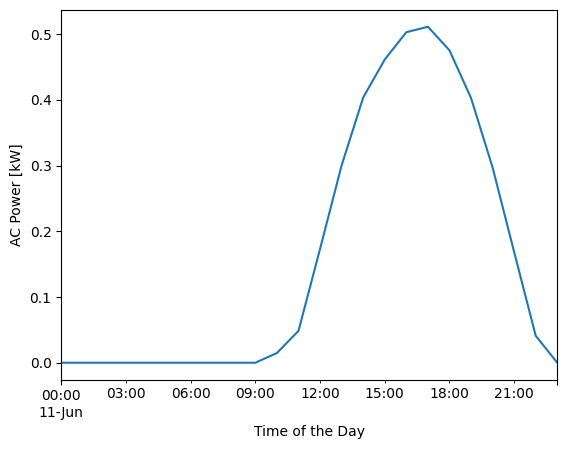

In [97]:
#Is one pannel enough for the worst day? 

flag = 0 # 0 = infufficient power production for worst day
n_panels = 1 #intial number of PV panels

while flag == 0: 

    #Calculate solar panel power production for worst day with n panels
    array = pvsystem.Array(mount=pvsystem.FixedMount(20, 180),
                        module_parameters=module_parameters,
                        temperature_model_parameters=temp_params, modules_per_string=n_panels)
    system = pvsystem.PVSystem(arrays=[array], inverter_parameters={'pdc0': 1, 'eta_inv_nom':0.95, 'strings_per_inverter':1 })
    mc2 = modelchain.ModelChain(system, loc, spectral_model='no_loss')
    _ = mc2.run_model(weather)
    
    #Check if enough power is produced for worst day
    n_hours = 0 # hours with power greater than or equal to max_power
    for i in range(len(mc2.results.ac)):
        if mc2.results.ac.iloc[i] >= max_power:
            n_hours += 1

    if n_hours >= time_min:
        flag = 1
        print(f"{n_panels} panels is enough for {time_min} hours of power for the worst day with {max_power:.2f} kW of max power")
        break
    else:
        print(f'{n_panels} panels is NOT enough') 
        n_panels += 1

    if n_panels > 10: #safty check
        print(f"Could not find enough panels with 10 panels")
        
mc2.results.ac.plot()
plt.xlabel('Time of the Day')
plt.ylabel('AC Power [kW]')

In [165]:
#How about for the entire historical data set? 

df_daily_irrigation =  pd.read_pickle('../NetworkCode/df_areas.pkl') #daily irrigation need in m3/day for 1h, 2ha and 3ha 
df_daily_irrigation['1ha_hrs'] = df_daily_irrigation['1 ha'] / (max_flow_rate* 3600) # convert to hrs
df_daily_irrigation['2ha_hrs'] = df_daily_irrigation['2 ha'] / (max_flow_rate* 3600) 
df_daily_irrigation['3ha_hrs'] = df_daily_irrigation['3 ha'] / (max_flow_rate* 3600) 
df_daily_irrigation.index = pd.to_datetime(df_daily_irrigation.index)


#create full weather data set
df_weather_full = df_weather_CEBIVE_raw[(df_weather_CEBIVE_raw['location'] == 'CEBIVE')]
df_weather_full.index = pd.to_datetime(df_weather_full['iso_date'])
weather_full = pd.DataFrame({
    'ghi': df_weather_full['Cloudy_sky.ghi'], 'dhi': df_weather_full['Cloudy_sky.dhi'], 'dni': df_weather_full['Cloudy_sky.dni'],
    'temp_air':  df_weather_full['Temp'], 'wind_speed':  df_weather_full['wind_speed'], 
})

#run PVlib model for full year
loc = location.Location(18.541, -69.990, -4.00, 32.0) #CEBIVE
solpos = loc.get_solarposition(weather_full.index)
module_parameters = {'pdc0': 0.35, 'gamma_pdc': -0.004, 'b': 0.05} #350W pannel 
temp_params = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

array_full = pvsystem.Array(mount=pvsystem.FixedMount(20, 180),
                        module_parameters=module_parameters,
                        temperature_model_parameters=temp_params, modules_per_string=n_panels)
system_full = pvsystem.PVSystem(arrays=[array_full], inverter_parameters={'pdc0': 1, 'eta_inv_nom':0.95, 'strings_per_inverter':1 })
mc_full = modelchain.ModelChain(system_full, loc, spectral_model='no_loss')
_ = mc_full.run_model(weather_full)

df_solar_full = pd.DataFrame({'solar_power': mc_full.results.ac})


#see if enough power is available each day for 1ha
weather_full_index = pd.to_datetime(weather_full.index.date).unique()

for day in weather_full_index.date:
    print(day)
    daily_power = df_solar_full.loc[df_solar_full.index.date == day]
   
    n_hrs = 0 # hours with power greater than or equal to max_power
    for i in range(len(daily_power)):
        if daily_power['solar_power'].iloc[i] >= max_power:
            n_hrs += 1  
    
    day_timestamp = pd.Timestamp(day)
    if day_timestamp in df_daily_irrigation.index:
        day_loc = df_daily_irrigation.index.get_loc(day_timestamp)  

        if n_hrs >= df_daily_irrigation['1ha_hrs'].iloc[day_loc]:
            print(f"{day} has enough power for 1ha")
        else:
            print(f"{day} does not have enough power for 1ha, {df_daily_irrigation['1ha_hrs'].iloc[day_loc] - n_hrs} hours short")

            break 
    else: 
         print(f"{day} is not found in df_daily_irrigation index")


##Fails on 2010-01-03 --> how to take into acount variable speed when power is less than max power



2010-01-01
2010-01-01 has enough power for 1ha
2010-01-02
2010-01-02 has enough power for 1ha
2010-01-03
2010-01-03 does not have enough power for 1ha, 0.9178823529411766 hours short


In [163]:
#accouting for variable speed operation




datetime.date(2010, 1, 1)